# Artificial Neural Network

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [39]:
df = pd.read_csv('dataset.csv')

C:\Users\raksh\AppData\Local\Temp\ipykernel_12064\112859877.py:1: DtypeWarning: Columns (22,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('dataset.csv')


- Data Quality (Missing Values): We favor features with a reasonably high percentage of valid data (generally, those with at least about 50% non‐missing values) so that imputation is feasible.
- Domain Relevance: We keep features that are likely to carry useful information about the engine’s status (e.g., sensor readings, diagnostic codes) and drop those that are either redundant (or merely identifiers) or have no predictive value.

In [41]:
cols_to_drop = [
    'AUTOMATIC', 'BAROMETRIC_PRESSURE(KPA)', 'FUEL_LEVEL', 'AMBIENT_AIR_TEMP', 
    'INTAKE_MANIFOLD_PRESSURE', 'MAF', 'LONG TERM FUEL TRIM BANK 2', 'FUEL_TYPE', 
    'FUEL_PRESSURE', 'SHORT TERM FUEL TRIM BANK 2', 'ENGINE_RUNTIME', 'TROUBLE_CODES', 
    'EQUIV_RATIO', 'TIMESTAMP', 'VEHICLE_ID', 'DTC_NUMBER'
]
df.drop(columns=cols_to_drop, errors='ignore', inplace=True)

#### Feature Selection

In [42]:
feature_cols = [
    'MARK', 'MODEL', 'CAR_YEAR', 'ENGINE_POWER', 'ENGINE_COOLANT_TEMP', 
    'ENGINE_LOAD', 'ENGINE_RPM', 'AIR_INTAKE_TEMP', 'SPEED', 
    'SHORT TERM FUEL TRIM BANK 1', 'THROTTLE_POS', 
    'TIMING_ADVANCE', 'MIN', 'HOURS', 'DAYS_OF_WEEK', 'MONTHS', 'YEAR'
]

In [40]:
if 'DTC_NUMBER' in df.columns:
    # Fill missing values in DTC_NUMBER if needed; here, we assume missing means healthy.
    df['DTC_NUMBER'] = df['DTC_NUMBER'].fillna('MIL is OFF0 codes')
    
    # Create the EngineHealth column based on DTC_NUMBER
    df['EngineHealth'] = df['DTC_NUMBER'].apply(lambda x: 0 if x.strip() == 'MIL is OFF0 codes' else 1)
    print("Created 'EngineHealth' column based on DTC_NUMBER.")
else:
    raise ValueError("DTC_NUMBER column not found in the dataset. Cannot create EngineHealth target.")

Created 'EngineHealth' column based on DTC_NUMBER.


In [43]:
# Create a new DataFrame with only the features of interest and the target
df_model = df[feature_cols + ['EngineHealth']].copy()
df_model.dropna(subset=['EngineHealth'], inplace=True)

In [45]:
#Split Data into Features and Target
X = df_model[feature_cols]
y = df_model['EngineHealth']

In [46]:
# Preprocessing pipeline
categorical_features = ['MARK', 'MODEL']
numeric_features = [col for col in feature_cols if col not in categorical_features]
# Pipeline for numeric features: impute missing values and scale them.
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline for categorical features: impute missing values and one-hot encode.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine numeric and categorical pipelines.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [47]:
# split data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit and transform the training data and transform the test data.
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

## Model of ANN

In [48]:
# Build the ANN model
# Determine the input dimension (number of features after preprocessing)
input_dim = X_train_processed.shape[1]

model = Sequential()
model.add(Dense(64, input_dim=input_dim, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
# For binary classification use 1 neuron with a sigmoid activation.
model.add(Dense(1, activation='sigmoid'))
# Compile the model. If your target is binary, use binary_crossentropy.
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

c:\Users\raksh\anaconda3\envs\unet_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Train the model

In [49]:
# Train the model
# Use early stopping to prevent overfitting.
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_processed, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)


Epoch 1/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9549 - loss: 0.1212 - val_accuracy: 0.9992 - val_loss: 0.0034
Epoch 2/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9992 - loss: 0.0028 - val_accuracy: 0.9995 - val_loss: 0.0022
Epoch 3/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9995 - loss: 0.0015 - val_accuracy: 0.9995 - val_loss: 0.0021
Epoch 4/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9997 - loss: 0.0012 - val_accuracy: 0.9995 - val_loss: 0.0022
Epoch 5/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9999 - loss: 4.8488e-04 - val_accuracy: 0.9996 - val_loss: 0.0022
Epoch 6/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9994 - loss: 0.0013 - val_accuracy: 0.9996 - val_loss: 0.0025
Epoch 7/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9998 - loss: 6.1163e-04 - val_accuracy: 0.9995 - val_loss: 0.0021
Epoch 8/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9998 - loss: 7.8878e-04 - val_

### Evaluation of the model

In [50]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_processed, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')


297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9994 - loss: 0.0034
Test Loss: 0.0053, Test Accuracy: 0.9994


In [51]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, log_loss, matthews_corrcoef, balanced_accuracy_score, 
                             cohen_kappa_score, confusion_matrix)

In [52]:
from matplotlib import pyplot as plt

297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


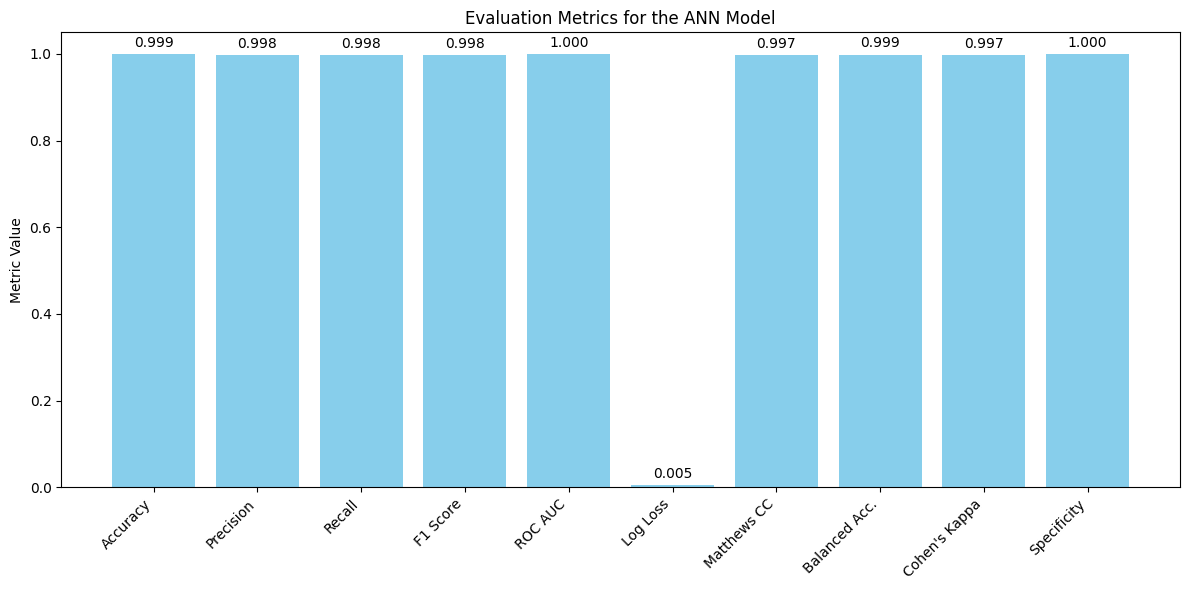

In [53]:
# Compute predictions (probabilities and class labels)
y_pred_proba = model.predict(X_test_processed)
y_pred = (y_pred_proba >= 0.5).astype(int).flatten()  # Flatten to 1D array if necessary

# Compute 10 Evaluation Metrics
# 1. Accuracy
acc = accuracy_score(y_test, y_pred)
# 2. Precision
prec = precision_score(y_test, y_pred)
# 3. Recall
rec = recall_score(y_test, y_pred)
# 4. F1 Score
f1 = f1_score(y_test, y_pred)
# 5. ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
# 6. Log Loss
ll = log_loss(y_test, y_pred_proba)
# 7. Matthews Correlation Coefficient
mcc = matthews_corrcoef(y_test, y_pred)
# 8. Balanced Accuracy
bal_acc = balanced_accuracy_score(y_test, y_pred)
# 9. Cohen's Kappa Score
kappa = cohen_kappa_score(y_test, y_pred)
# 10. Specificity (TN / (TN + FP))
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

# Create a dictionary of metrics for plotting.
metrics_dict = {
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1 Score": f1,
    "ROC AUC": roc_auc,
    "Log Loss": ll,
    "Matthews CC": mcc,
    "Balanced Acc.": bal_acc,
    "Cohen's Kappa": kappa,
    "Specificity": specificity
}

# --------------------------
# 12. Plot the Evaluation Metrics
# --------------------------
plt.figure(figsize=(12, 6))
bars = plt.bar(metrics_dict.keys(), metrics_dict.values(), color='skyblue')
plt.title("Evaluation Metrics for the ANN Model")
plt.ylabel("Metric Value")
plt.xticks(rotation=45, ha="right")

# Annotate each bar with its value
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.3f}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.tight_layout()
plt.show()